<h1>Capstone 1</h1>
<h2>White Wine Quality - KNN, UC Irvine</h2> 
(Source: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009)
<h4>Audrey Rager</h4>
<h4>October 27, 2020</h4>
<h2>Import Python Packages</h2>

In [2]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.stats.weightstats as smsw
import pylab

# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
#from sklearn import cross_validation
from scipy import stats as st
import warnings 
warnings.filterwarnings('ignore')

# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')


<h2>Data Wrangling</h2>

In [3]:
#Import csv files into Pandas data frames
#reddf = pd.read_csv('winequality-red.csv',sep=";")
whitedf = pd.read_csv('winequality-white.csv',sep=";")
df = pd.read_csv('winequality-white.csv',sep=";")
df = df.rename({'fixed acidity': 'fixed_acidity','volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar':'residual_sugar',  'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'}, axis=1)

df.describe()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


<h2>Identifying and Removing Outliers</h2>
<p>A predictor variable is considered to be an outlier only if it is > Q<sub>3</sub> + 1.5 IQR. Because all skewed data are positively skewed, we only need to eliminate those values.</p>

In [4]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
ValueList = ('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
            'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol')

for myValue in ValueList:
    #compute range of data
    myValueMax = df[myValue].max()
    myValueMin = df[myValue].min()
    myValueRange = myValueMax - myValueMin
    
    # Computing IQR
    Q1 = df[myValue].quantile(0.25)
    Q3 = df[myValue].quantile(0.75)
    IQR = Q3 - Q1
    gtdropvalue = (Q3 + (1.5 * IQR))
    ltdropvalue = (Q1 - (1.5 * IQR))
    
    index_names_right = df[df[myValue] >= gtdropvalue].index
    index_names_left = df[df[myValue] <= ltdropvalue].index
    df.drop(index_names_right, inplace = True)
    df.drop(index_names_left, inplace = True)
    
    
   

In [5]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000
mean,6.809048,0.263828,0.322749,6.352759,0.042299,34.730575,136.953176,0.993844,3.189043,0.481445,10.592035,5.953936
std,0.726417,0.076298,0.083076,4.905477,0.009889,14.941739,41.049024,0.002877,0.137980,0.098904,1.214421,0.856194
min,4.900000,0.080000,0.110000,0.600000,0.016000,2.000000,19.000000,0.987110,2.830000,0.220000,8.400000,3.000000
25%,6.300000,0.210000,0.270000,1.800000,0.035000,24.000000,107.000000,0.991580,3.100000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.310000,5.200000,0.042000,34.000000,132.000000,0.993520,3.180000,0.470000,10.500000,6.000000
75%,7.300000,0.310000,0.370000,9.600000,0.049000,45.000000,166.000000,0.995870,3.280000,0.540000,11.400000,6.000000
max,8.700000,0.485000,0.540000,20.800000,0.071000,78.000000,253.000000,1.001960,3.570000,0.760000,14.200000,9.000000


## Standardize the Independent Variables


In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

In [9]:
scaler.fit(df.drop('quality',axis=1))

StandardScaler()

In [10]:
scaled_features = scaler.transform(df.drop('quality',axis=1))

In [16]:
#use slice to cut off last column - quality, which is the target variable

df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.262901,0.080901,0.448458,2.925110,0.273136,0.687385,0.805159,2.487672,-1.370247,-0.317978,-1.475816
1,-0.700854,0.474145,0.207684,-0.968990,0.677694,-1.387603,-0.120680,0.054234,0.804250,0.086507,-0.899337
2,1.777374,0.211983,0.930006,0.111571,0.778834,-0.316641,-0.973427,0.436631,0.514317,-0.419099,-0.405212
3,0.538260,-0.443424,-0.033090,0.437779,1.587950,0.821255,1.194987,0.610448,0.006935,-0.823584,-0.569920
4,0.538260,-0.443424,-0.033090,0.437779,1.587950,0.821255,1.194987,0.610448,0.006935,-0.823584,-0.569920


In [18]:
df_feat.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,3.951000e+03,3.951000e+03,3.951000e+03,3.951000e+03,3.951000e+03,3.951000e+03,3.951000e+03,3.951000e+03,3.951000e+03,3.951000e+03,3.951000e+03
mean,5.754839e-16,3.165161e-16,-4.028387e-16,-6.204435e-17,3.021290e-16,-7.283468e-17,2.014194e-16,-1.071839e-14,-1.726452e-16,7.193548e-18,1.194129e-15
std,1.000127e+00,1.000127e+00,1.000127e+00,1.000127e+00,1.000127e+00,1.000127e+00,1.000127e+00,1.000127e+00,1.000127e+00,1.000127e+00,1.000127e+00
min,-2.628365e+00,-2.409644e+00,-2.561219e+00,-1.172870e+00,-2.659912e+00,-2.190824e+00,-2.873835e+00,-2.340965e+00,-2.602463e+00,-2.643767e+00,-1.805233e+00
25%,-7.008545e-01,-7.055865e-01,-6.350258e-01,-9.282146e-01,-7.382599e-01,-7.182519e-01,-7.297851e-01,-7.870404e-01,-6.454147e-01,-7.224630e-01,-8.993369e-01
50%,-1.245770e-02,-5.017983e-02,-1.534775e-01,-2.350240e-01,-3.028299e-02,-4.890107e-02,-1.206802e-01,-1.126304e-01,-6.554864e-02,-1.157354e-01,-7.579465e-02
75%,6.759391e-01,6.052268e-01,5.688449e-01,6.620462e-01,6.776940e-01,6.873849e-01,7.077026e-01,7.043095e-01,6.592839e-01,5.921136e-01,6.653934e-01
max,2.603450e+00,2.899150e+00,2.615425e+00,2.945497e+00,2.902764e+00,2.896243e+00,2.827388e+00,2.821401e+00,2.761298e+00,2.816782e+00,2.971312e+00


## Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['quality'],
                                                    test_size=0.25)


## Using KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
#Start with 1
knn = KNeighborsClassifier(n_neighbors=1)

In [27]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [28]:
pred = knn.predict(X_test)

## Predictions and Evaluations

In [29]:
from sklearn.metrics import classification_report,confusion_matrix

In [30]:
print(confusion_matrix(y_test,pred))

[[  0   1   0   1   0   1]
 [  0   7   3   8   1   0]
 [  0   6 156  77  11   1]
 [  0   6  90 301  64   8]
 [  0   0  12  70 121  12]
 [  0   0   3   6   5  17]]


In [31]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.35      0.37      0.36        19
           5       0.59      0.62      0.61       251
           6       0.65      0.64      0.65       469
           7       0.60      0.56      0.58       215
           8       0.44      0.55      0.49        31

    accuracy                           0.61       988
   macro avg       0.44      0.46      0.45       988
weighted avg       0.61      0.61      0.61       988



## Choosing a K Value

Use the elbow method to pick a good K Value:

In [32]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [33]:
error_rate

[0.39068825910931176,
 0.42611336032388664,
 0.4230769230769231,
 0.43623481781376516,
 0.4423076923076923,
 0.4392712550607287,
 0.4331983805668016,
 0.45445344129554655,
 0.43724696356275305,
 0.444331983805668,
 0.4433198380566802,
 0.4493927125506073,
 0.45445344129554655,
 0.44635627530364375,
 0.4483805668016194,
 0.4473684210526316,
 0.444331983805668,
 0.444331983805668,
 0.4382591093117409,
 0.444331983805668,
 0.4423076923076923,
 0.4423076923076923,
 0.4382591093117409,
 0.44534412955465585,
 0.4423076923076923,
 0.4230769230769231,
 0.42813765182186236,
 0.4271255060728745,
 0.43724696356275305,
 0.43623481781376516,
 0.44129554655870445,
 0.4402834008097166,
 0.4423076923076923,
 0.43623481781376516,
 0.4331983805668016,
 0.43623481781376516,
 0.43623481781376516,
 0.4423076923076923,
 0.43724696356275305]

Text(0, 0.5, 'Error Rate')

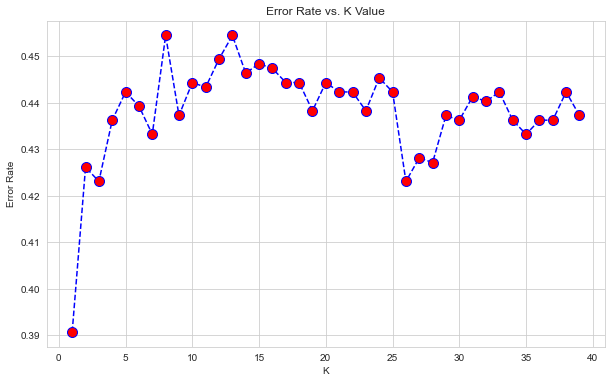

In [34]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [35]:
# FIRST A QUICK COMPARISON TO OUR ORIGINAL K=1
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=1


[[  0   1   0   1   0   1]
 [  0   7   3   8   1   0]
 [  0   6 156  77  11   1]
 [  0   6  90 301  64   8]
 [  0   0  12  70 121  12]
 [  0   0   3   6   5  17]]


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.35      0.37      0.36        19
           5       0.59      0.62      0.61       251
           6       0.65      0.64      0.65       469
           7       0.60      0.56      0.58       215
           8       0.44      0.55      0.49        31

    accuracy                           0.61       988
   macro avg       0.44      0.46      0.45       988
weighted avg       0.61      0.61      0.61       988



In [36]:
# NOW WITH K=5
knn = KNeighborsClassifier(n_neighbors=23)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=5')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=5


[[  0   0   1   2   0   0]
 [  0   0  10   9   0   0]
 [  0   0 146 102   3   0]
 [  0   0  99 336  34   0]
 [  0   0   8 133  73   1]
 [  0   0   1  15  15   0]]


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        19
           5       0.55      0.58      0.57       251
           6       0.56      0.72      0.63       469
           7       0.58      0.34      0.43       215
           8       0.00      0.00      0.00        31

    accuracy                           0.56       988
   macro avg       0.28      0.27      0.27       988
weighted avg       0.53      0.56      0.54       988

